This Notebook contains the below metioned information taught by Raschka
- Bare min native pytorch setup for Multiclass classification as explained in the course - https://lightning.ai/courses/deep-learning-fundamentals/overview-organizing-your-code-with-pytorch-lightning/
- Application pytorch lightning on basic modular transformation of code
- Application of TorchMetrics

In [1]:
%autosave 300
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch


##### Basic Setup of Pytorch Native Code

Downloading images of Mnist from github repo and basic data prep

In [3]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [4]:
import os
from git import Repo
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import numpy as np
import torchvision.utils as vutils
import torch.nn.functional as F
import torchmetrics
import lightning as L

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
if not os.path.exists("data/mnist-pngs"):
    Repo.clone_from("https://github.com/rasbt/mnist-pngs", "data/mnist-pngs")

In [7]:
# the csv file contains all the necessary information about the data path and labels
train_label_df = pd.read_csv(r"data/mnist-pngs/train.csv")
test_label_df = pd.read_csv(r"data/mnist-pngs/test.csv")

In [8]:
print(train_label_df.head())
print(train_label_df.shape)
print(test_label_df.shape)

            filepath  label
0  train/0/16585.png      0
1  train/0/24537.png      0
2  train/0/25629.png      0
3  train/0/20751.png      0
4  train/0/34730.png      0
(60000, 2)
(10000, 2)


In [9]:
# Randomize the labels and then split by 75-25 % as train & validation set
train_label_df = train_label_df.sample(frac=1.0, random_state=101).reset_index(drop=True)
print(train_label_df.shape)

(60000, 2)


In [10]:
split_ratio = 0.75
train_df = train_label_df.loc[: len(train_label_df) * split_ratio].reset_index(
    drop=True
)
val_df = train_label_df.loc[len(train_label_df) * split_ratio :].reset_index(drop=True)
print(train_df.shape, val_df.shape)

(45001, 2) (15000, 2)


Preparing the data for modelling based on the application of augmentations provided by transform package and creating the dataloder for train/val/test dataset

In [11]:
# data transformation
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(32),
            transforms.RandomCrop((28, 28)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "test": transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    ),
}

In [12]:
class MnistDataset(Dataset):
    def __init__(self, file_df, img_dir, transform=None):
        self.file_df = file_df
        self.img_dir = img_dir
        self.transform = transform

        self.image_path = self.file_df["filepath"]
        self.labels = self.file_df["label"]

    def __len__(self):
        return self.file_df.shape[0]

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.img_dir, self.image_path[idx]))
        if self.transform is not None:
            image = self.transform(image)

        label = self.labels[idx]
        return image.to(torch.float32), torch.tensor(label).to(torch.int64)

In [13]:
# creating all the datsets
train_dataset = MnistDataset(
    file_df=train_df, img_dir="data/mnist-pngs", transform=data_transforms["train"]
)

valid_dataset = MnistDataset(
    file_df=val_df, img_dir="data/mnist-pngs", transform=data_transforms["test"]
)

test_dataset = MnistDataset(
    file_df=test_label_df, img_dir="data/mnist-pngs", transform=data_transforms["test"]
)

In [14]:
for data, label in test_dataset:
    print(data.shape, label)
    break

print(len(train_dataset), len(valid_dataset), len(test_dataset))

torch.Size([1, 28, 28]) tensor(0)
45001 15000 10000


In [15]:
for data, label in valid_dataset:
    print(data.shape, label)
    break


torch.Size([1, 28, 28]) tensor(1)


In [16]:
# Create Dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    drop_last=True,
)
valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=512,
    num_workers=8,
    shuffle=False,
    drop_last=False,
    pin_memory=True,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=1024,
    shuffle=False,
    num_workers=8,
)

/home/azureuser/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
for data, label in train_dataloader:
    print(data.shape, label.shape)
    break

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([256, 1, 28, 28]) torch.Size([256])


In [18]:
for data, label in valid_dataloader:
    print(data.shape, label.shape)
    break

torch.Size([512, 1, 28, 28]) torch.Size([512])


In [19]:
def viz_batch_images(batch):

    plt.figure(figsize=(13, 11))
    plt.axis("off")
    plt.title("Training images")
    plt.imshow(
        np.transpose(
            vutils.make_grid(batch[0][:32], padding=2, normalize=True), (1, 2, 0)
        )
    )
    plt.show()

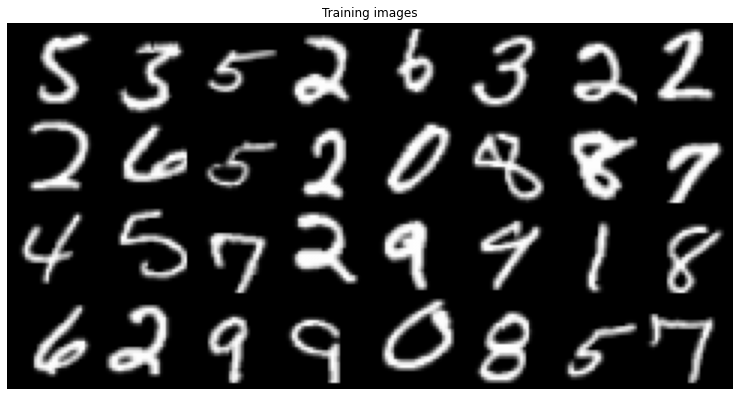

In [20]:
test_batch = next(iter(train_dataloader))
viz_batch_images(test_batch)

Model Definition and Model Training

In [21]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 50),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(25, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

In [22]:
def prediction_loop(model, dataloader):

    model = model.eval()

    correct = 0.0
    total_examples = 0

    for idx, (features, labels) in enumerate(dataloader):
        features = features.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)

        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

In [23]:
torch.manual_seed(1)
model = PyTorchMLP(num_features=784, num_classes=10).to(device)

In [24]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 2

Normal Training loop

In [25]:
# loss_list = []
# train_acc_list, val_acc_list = [], []
# for epoch in range(num_epochs):

#     model = model.train()
#     for batch_idx, (features, labels) in enumerate(train_dataloader):
#         features = features.to(device)
#         labels = labels.to(device)

#         logits = model(features)

#         loss = criterion(logits, labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         ### LOGGING
#         print(
#             f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
#             f" | Batch {batch_idx:03d}/{len(train_dataloader):03d}"
#             f" | Train Loss: {loss:.2f}"
#         )
#         loss_list.append(loss.item())

#     train_acc = prediction_loop(model, train_dataloader)
#     val_acc = prediction_loop(model, valid_dataloader)
#     print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")
#     train_acc_list.append(train_acc)
#     val_acc_list.append(val_acc)

#### Basic of Lightning

Model Trainer - We will use a new model trainer but will still persist with Original Model and evaluation loop

In [26]:
class PyTorchMLPLightning(L.LightningModule):
    def __init__(self, model, learning_rate):
        super(PyTorchMLPLightning, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, label = batch
        logits = self(features)
        loss = self.criterion(logits, label)
        self.log(name="train_loss", value=loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        features, label = batch
        logits = self(features)
        loss = self.criterion(logits, label)
        self.log(name="val_loss", value=loss, prog_bar=True)

    def configure_optimizers(
        self,
    ):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

In [27]:
pytorch_model = PyTorchMLP(num_features=784, num_classes=10).to(device)
lightning_model = PyTorchMLPLightning(
    model=pytorch_model,
    learning_rate=0.05,
)

In [28]:
# setting up the trainer module
trainer = L.Trainer(
    max_epochs=3,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
# setting up the fit model
trainer.fit(
    model=lightning_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | PyTorchMLP       | 40.8 K
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/home/azureuser/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=3` reached.


In [30]:
# lightning_model.cuda()

In [31]:
# pytorch_model.cpu()

In [33]:
# val_acc = prediction_loop(lightning_model, valid_dataloader)
# test_acc = prediction_loop(lightning_model, test_dataloader)

In [34]:
# print(
#         f" | Val Acc {val_acc*100:.2f}%"
#         f" | Test Acc {test_acc*100:.2f}%"
#     )

Addition of Torch Metrics to calculate the metrics -We include the accuaracy calculation process within trainer itself

In [35]:
class PyTorchMLPLightning(L.LightningModule):
    def __init__(self, model, learning_rate):
        super(PyTorchMLPLightning, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x: torch.Tensor):
        """
        Forward computation of the model
        """
        return self.model(x)

    def _shared_step(self, batch):
        """
        Shared step for training and validation
        """
        features, label = batch
        logits = self(features)
        loss = self.criterion(logits, label)
        predictions = torch.argmax(logits, dim=1)
        return label, loss, predictions

    def training_step(self, batch, batch_idx):
        """
        Training Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="train_loss", value=loss, prog_bar=True)
        # metric calculation
        self.train_acc(predictions, label)
        self.log(
            name="train_acc",
            value=self.train_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="val_loss", value=loss, prog_bar=True)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="val_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def test_step(self, batch, batch_idx):
        """
        Test step metric calculation
        """
        label, loss, predictions = self._shared_step(batch)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="test_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def configure_optimizers(
        self,
    ):
        """
        Optimizer config
        """
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

In [36]:
# setting up the model
pytorch_model = PyTorchMLP(num_features=784, num_classes=10).to(device)
lightning_model = PyTorchMLPLightning(
    model=pytorch_model,
    learning_rate=0.05,
)

In [37]:
# setting up the trainer module
trainer = L.Trainer(
    max_epochs=3,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:
# setting up the fit model
trainer.fit(
    model=lightning_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 40.8 K
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

In [ ]:
# triggering the test fit method
val_acc = trainer.test(dataloaders=valid_dataloader)
test_acc = trainer.test(dataloaders=test_dataloader)
print(f" | Val Acc {str(val_acc)}%" f" | Test Acc {str(test_acc)}%")

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/lightning_logs/version_5/checkpoints/epoch=2-step=525.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/lightning_logs/version_5/checkpoints/epoch=2-step=525.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7094558477401733     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/lightning_logs/version_5/checkpoints/epoch=2-step=525.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/lightning_logs/version_5/checkpoints/epoch=2-step=525.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7170000076293945     │
└───────────────────────────┴───────────────────────────┘

 | Val Acc [{'test_acc': 0.7094558477401733}]% | Test Acc [{'test_acc': 0.7170000076293945}]%


The process is super slow due to reading of Image, for which in next notebook onwards we will focus on reading the data directly from the vision package